# Baselines for TCR
The notebook `dataset-creation.ipyn` creates two dataset: the `α+β set`, and the `β set`. The `α+β set` contains `(CDR3α, CDR3β, peptide)` samples. The `β set` contains `(CDR3β, peptide)` samples.

In this notebook, we do experiments on ERGO II, NetTCR2.0, and LUPI-SVM using them as baseline for our research. We train and test on the `α+β set`

For testing, we operate 5 independent train/test splits of `α+β set` with different random seeds.

## Utility functions

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm import trange
import random
import math
from scipy import interp
import statistics 

from tcrmodels.ergo2.model import ERGO2
from tcrmodels.nettcr2.model import NetTCR2

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import collections
from matplotlib import colors
from numpy.random import normal

Using TensorFlow backend.


In [2]:
metrics = [
    'AUROC',
    'Accuracy',
    #'Recall',
    'Precision',
    'F1 score',
    'AUPR'
]

def pr_auc(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    return pr_auc

def get_scores(y_true, y_prob, y_pred):
    """
    Compute a df with all classification metrics and respective scores.
    """
    
    scores = [
        roc_auc_score(y_true, y_prob),
        accuracy_score(y_true, y_pred),
        #recall_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        f1_score(y_true, y_pred),
        pr_auc(y_true, y_prob)
    ]
    
    df = pd.DataFrame(data={'score': scores, 'metrics': metrics})
    return df

In [3]:
blosum50_20aa = {
    'A': np.array((5,-2,-1,-2,-1,-1,-1,0,-2,-1,-2,-1,-1,-3,-1,1,0,-3,-2,0)),
    'R': np.array((-2,7,-1,-2,-4,1,0,-3,0,-4,-3,3,-2,-3,-3,-1,-1,-3,-1,-3)),
    'N': np.array((-1,-1,7,2,-2,0,0,0,1,-3,-4,0,-2,-4,-2,1,0,-4,-2,-3)),
    'D': np.array((-2,-2,2,8,-4,0,2,-1,-1,-4,-4,-1,-4,-5,-1,0,-1,-5,-3,-4)),
    'C': np.array((-1,-4,-2,-4,13,-3,-3,-3,-3,-2,-2,-3,-2,-2,-4,-1,-1,-5,-3,-1)),
    'Q': np.array((-1,1,0,0,-3,7,2,-2,1,-3,-2,2,0,-4,-1,0,-1,-1,-1,-3)),
    'E': np.array((-1,0,0,2,-3,2,6,-3,0,-4,-3,1,-2,-3,-1,-1,-1,-3,-2,-3)),
    'G': np.array((0,-3,0,-1,-3,-2,-3,8,-2,-4,-4,-2,-3,-4,-2,0,-2,-3,-3,-4)),
    'H': np.array((-2,0,1,-1,-3,1,0,-2,10,-4,-3,0,-1,-1,-2,-1,-2,-3,2,-4)),
    'I': np.array((-1,-4,-3,-4,-2,-3,-4,-4,-4,5,2,-3,2,0,-3,-3,-1,-3,-1,4)),
    'L': np.array((-2,-3,-4,-4,-2,-2,-3,-4,-3,2,5,-3,3,1,-4,-3,-1,-2,-1,1)),
    'K': np.array((-1,3,0,-1,-3,2,1,-2,0,-3,-3,6,-2,-4,-1,0,-1,-3,-2,-3)),
    'M': np.array((-1,-2,-2,-4,-2,0,-2,-3,-1,2,3,-2,7,0,-3,-2,-1,-1,0,1)),
    'F': np.array((-3,-3,-4,-5,-2,-4,-3,-4,-1,0,1,-4,0,8,-4,-3,-2,1,4,-1)),
    'P': np.array((-1,-3,-2,-1,-4,-1,-1,-2,-2,-3,-4,-1,-3,-4,10,-1,-1,-4,-3,-3)),
    'S': np.array((1,-1,1,0,-1,0,-1,0,-1,-3,-3,0,-2,-3,-1,5,2,-4,-2,-2)),
    'T': np.array((0,-1,0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1,2,5,-3,-2,0)),
    'W': np.array((-3,-3,-4,-5,-5,-1,-3,-3,-3,-3,-2,-3,-1,1,-4,-4,-3,15,2,-3)),
    'Y': np.array((-2,-1,-2,-3,-3,-1,-2,-3,2,-1,-1,-2,0,4,-3,-2,-2,2,8,-1)),
    'V': np.array((0,-3,-3,-4,-1,-3,-3,-4,-4,4,1,-3,1,-1,-3,-2,0,-3,-1,5))
}

def enc_list_bl_max_len(aas, blosum, max_seq_len):
    '''
    blosum encoding of a list of amino acid sequences with padding 
    to a max length

    parameters:
        - aa_seqs : list with AA sequences
        - blosum : dictionary: key= AA, value= blosum encoding
        - max_seq_len: common length for padding
    returns:
        padded_aa_encoding : array of padded amino acids encoding
    '''
    encoding_len = len(blosum['A'])
    padded_aa_encoding = np.zeros((encoding_len * max_seq_len))
    
    # encode amino acids
    for i, aa in enumerate(aas):
        padded_aa_encoding[i*encoding_len:(i+1)*encoding_len] = blosum[aa]
        
    return padded_aa_encoding

In [4]:
# Abbasi et al. implementation of LUPI-SVM does not predict probabilities
# we should do Platt scaling to estimate probabilities of a SVM
# but since that would be a complex implementation, we use a sigmoid
from scipy.stats import logistic

def sigmoid(x):
    return logistic.cdf(x)

In [5]:
import os
login = os.getlogin( )
DATA_BASE = f"/home/{login}/Git/tcr/data/"
RESULTS_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/results/"
# To run in github checkout of vibtcr, after `unzip data.zip` ...
RESULTS_BASE = os.path.join('.', 'results')
FIGURES_BASE = os.path.join('.', 'figures')
DATA_BASE = os.path.join('..', '..', 'data')

# NetTCR2.0 - Peptide+CDR3β

In [6]:
%%capture

df_dataset = pd.read_csv(os.path.join(DATA_BASE, "alpha-beta-splits", "alpha-beta.csv"))
test_files = ('(α+β-set(β-only)', [])
results_nettcr2 = []

for i in tqdm(range(5)):
    df_train, df_test = train_test_split(df_dataset, test_size=0.2, random_state=i)
    test_files[1].append(df_test.reset_index())

    model = NetTCR2(
        architecture="b", 
        single_chain_column='tcrb',
        peptide_column='peptide',
        label_column='sign',
        max_pep_len=df_dataset.peptide.str.len().max(), 
        max_cdr3_len=df_dataset.tcrb.str.len().max()
    )
    model.train(df_train, epochs=1000);

    prediction_df = model.test(test_files[1][i])
    scores_df = get_scores(
        y_true=prediction_df['sign'].to_numpy(), 
        y_prob=prediction_df['prediction'].to_numpy(),
        y_pred=prediction_df['prediction'].to_numpy().round(),
    )
    scores_df['experiment'] = "train_α+β-set(β-only)_test_"+test_files[0]
    results_nettcr2.append(scores_df)
    test_files[1][i]['prediction_'+str(i)] = prediction_df['prediction']
        
results_nettcr2_df = pd.concat(results_nettcr2)

# save results for further analysis
for i, test_file in enumerate(test_files[1]):
    test_file.to_csv(os.path.join(RESULTS_BASE, f"nettcr2.baseline.alpha+beta-only.rep-{i}.csv"), index=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



# NetTCR2.0 - Peptide+CDR3β+CDR3α

In [7]:
%%capture

df_dataset = pd.read_csv(os.path.join(DATA_BASE, "alpha-beta-splits", "alpha-beta.csv"))
test_files = ('(α+β-set(α+β)', [])
results_nettcr2 = []

for i in tqdm(range(5)):
    df_train, df_test = train_test_split(df_dataset, test_size=0.2, random_state=i)
    test_files[1].append(df_test.reset_index())

    model = NetTCR2(
        architecture="ab", 
        cdr3b_column='tcrb',
        cdr3a_column='tcra',
        peptide_column='peptide',
        label_column='sign',
        max_pep_len=df_dataset.peptide.str.len().max(), 
        max_cdr3b_len=df_dataset.tcrb.str.len().max(),
        max_cdr3a_len=df_dataset.tcra.str.len().max()
    )
    model.train(df_train, epochs=1000);

    prediction_df = model.test(test_files[1][i])
    scores_df = get_scores(
        y_true=prediction_df['sign'].to_numpy(), 
        y_prob=prediction_df['prediction'].to_numpy(),
        y_pred=prediction_df['prediction'].to_numpy().round(),
    )
    scores_df['experiment'] = "train_α+β-set(α+β)_test_"+test_files[0]
    results_nettcr2.append(scores_df)
    test_files[1][i]['prediction_'+str(i)] = prediction_df['prediction']
        
results_nettcr2_df = pd.concat(results_nettcr2)

# save results for further analysis
for i, test_file in enumerate(test_files[1]):
    test_file.to_csv(
        os.path.join(RESULTS_BASE, f"nettcr2.baseline.alpha+beta-only.alpha+beta+peptide.rep-{i}.csv"),
        index=False
    )

# ERGO II - Peptide+CDR3β

In [8]:
%%capture

# the ERGO II data presents some files with a given header, and some others with a different one
map_keys = {
    'tcra': 'TRA',
    'tcrb': 'TRB',
    'va': 'TRAV',
    'ja': 'TRAJ',
    'vb': 'TRBV',
    'jb': 'TRBJ',
    't_cell_type': 'T-Cell-Type',
    'peptide': 'Peptide',
    'mhc': 'MHC',
    'protein': 'protein',
    'sign': 'sign'
}

df_dataset = pd.read_csv(os.path.join(DATA_BASE, "alpha-beta-splits", "alpha-beta.csv"))
results_ergo2 = []
test_files = ('(α+β-set(β-only)', [])

for i in tqdm(range(5)):
    df_train, df_test = train_test_split(df_dataset, test_size=0.2, random_state=i)
    
    # the ERGO II implementation expected the following columns to be preset in the dataframe
    # even if they are not used
    df_test['va'] = pd.NA
    df_train['va'] = pd.NA
    df_test['vb'] = pd.NA
    df_train['vb'] = pd.NA
    df_test['ja'] = pd.NA
    df_train['ja'] = pd.NA
    df_test['jb'] = pd.NA
    df_train['jb'] = pd.NA
    df_test['mhc'] = pd.NA
    df_train['mhc'] = pd.NA
    df_test['t_cell_type'] = pd.NA
    df_train['t_cell_type'] = pd.NA
    df_test['protein'] = pd.NA
    df_train['protein'] = pd.NA

    # using "UNK" for identifier of missing CDR3α for test set
    df_test['tcra'] = "UNK"

    df_test = df_test.rename(columns={c: map_keys[c] for c in df_test.columns})
    
    test_files[1].append(df_test.reset_index())

    model = ERGO2(
        gpu=[0],
        use_alpha=False,
        random_seed=i,
        train_val_ratio=.2,
    )
    model.train(df_train);

    prediction_df = model.test(test_files[1][i])
    scores_df = get_scores(
        y_true=prediction_df['sign'].to_numpy(), 
        y_prob=prediction_df['prediction'].to_numpy(),
        y_pred=prediction_df['prediction'].to_numpy().round(),
    )
    scores_df['experiment'] = "train_α+β-set(β-only)_test_"+test_files[0]
    results_ergo2.append(scores_df)
    test_files[1][i]['prediction_'+str(i)] = prediction_df['prediction']
        
results_ergo2_df = pd.concat(results_ergo2)

# save results for further analysis
for i, test_file in enumerate(test_files[1]):
    test_file.to_csv(os.path.join(RESULTS_BASE, f"ergo2.baseline.alpha+beta-only.rep-{i}.csv"), index=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type         | Params
-----------------------------------------------
0 | tcrb_encoder  | LSTM_Encoder | 3 M   
1 | pep_encoder   | LSTM_Encoder | 3 M   
2 | hidden_layer1 | Linear       | 31 K  
3 | relu          | LeakyReLU    | 0     
4 | output_layer1 | Linear       | 32    
5 | dropout       | Dropout      | 0     
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type         | Params
-----------------------------------------------
0 | tcrb_encoder  | LSTM_Encoder | 3 M   
1 | pep_encoder   | LSTM_Encoder | 3 M   
2 | hidden_layer1 | Linear       | 31 K  
3 | relu          | LeakyReLU    | 0     
4 | output_layer1 | Linear       | 32    
5 | dropout       | Dropout      | 0     
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name        

# ERGO II - Peptide+CDR3β+CDR3α

In [9]:
%%capture

# the ERGO II data presents some files with a given header, and some others with a different one
map_keys = {
    'tcra': 'TRA',
    'tcrb': 'TRB',
    'va': 'TRAV',
    'ja': 'TRAJ',
    'vb': 'TRBV',
    'jb': 'TRBJ',
    't_cell_type': 'T-Cell-Type',
    'peptide': 'Peptide',
    'mhc': 'MHC',
    'protein': 'protein',
    'sign': 'sign'
}

df_dataset = pd.read_csv(os.path.join(DATA_BASE, "alpha-beta-splits", "alpha-beta.csv"))
results_ergo2 = []
test_files = ('(α+β-set(α+β)', [])

for i in tqdm(range(5)):
    df_train, df_test = train_test_split(df_dataset, test_size=0.2, random_state=i)
    
    # the ERGO II implementation expected the following columns to be preset in the dataframe
    # even if they are not used
    df_test['va'] = pd.NA
    df_train['va'] = pd.NA
    df_test['vb'] = pd.NA
    df_train['vb'] = pd.NA
    df_test['ja'] = pd.NA
    df_train['ja'] = pd.NA
    df_test['jb'] = pd.NA
    df_train['jb'] = pd.NA
    df_test['mhc'] = pd.NA
    df_train['mhc'] = pd.NA
    df_test['t_cell_type'] = pd.NA
    df_train['t_cell_type'] = pd.NA
    df_test['protein'] = pd.NA
    df_train['protein'] = pd.NA

    df_test = df_test.rename(columns={c: map_keys[c] for c in df_test.columns})
    
    test_files[1].append(df_test.reset_index())

    model = ERGO2(
        gpu=[0],
        use_alpha=True,
        random_seed=i,
        train_val_ratio=.2,
    )
    model.train(df_train);

    prediction_df = model.test(test_files[1][i])
    scores_df = get_scores(
        y_true=prediction_df['sign'].to_numpy(), 
        y_prob=prediction_df['prediction'].to_numpy(),
        y_pred=prediction_df['prediction'].to_numpy().round(),
    )
    scores_df['experiment'] = "train_α+β-set(α+β)_test_"+test_files[0]
    results_ergo2.append(scores_df)
    test_files[1][i]['prediction_'+str(i)] = prediction_df['prediction']
        
results_ergo2_df = pd.concat(results_ergo2)

# save results for further analysis
for i, test_file in enumerate(test_files[1]):
    test_file.to_csv(os.path.join(RESULTS_BASE, f"ergo2.baseline.alpha+beta-only.alpha+beta+peptide.rep-{i}.csv"), index=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type         | Params
-----------------------------------------------
0 | tcra_encoder  | LSTM_Encoder | 3 M   
1 | tcrb_encoder  | LSTM_Encoder | 3 M   
2 | pep_encoder   | LSTM_Encoder | 3 M   
3 | hidden_layer1 | Linear       | 31 K  
4 | relu          | LeakyReLU    | 0     
5 | output_layer1 | Linear       | 32    
6 | dropout       | Dropout      | 0     
7 | hidden_layer2 | Linear       | 57 K  
8 | output_layer2 | Linear       | 39    
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type         | Params
-----------------------------------------------
0 | tcra_encoder  | LSTM_Encoder | 3 M   
1 | tcrb_encoder  | LSTM_Encoder | 3 M   
2 | pep_encoder   | LSTM_Encoder | 3 M   
3 | hidden_layer1 | Linear       | 31 K  
4 | relu          | LeakyReLU    | 0     
5 | output_layer1 | Linear      

# LUPI-SVM - CDR3α-privileged
Learning protein binding affinity using privileged information, Abbasi et al., BMC Bioinformatics, 2018

Paper: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2448-z

Code: https://github.com/wajidarshad/LUPI-SVM

In [10]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 20 00:59:45 2017

@author: Wajid Arshad Abbasi

This module contains the class definitions for the Stochastic subgradient descent based large margin classifiers for Learning Using Privileged Information (LUPI)

"""
class ClassifierBase:
    """
    This is the base class for LUPI
    """
    
    def __init__(self,**kwargs):
    
        if 'epochs' in kwargs:
            self.epochs=kwargs['epochs']
        else:
            self.epochs=100
        if 'Lambda' in kwargs:
            self.Lambda=kwargs['Lambda']
        else:
            self.Lambda=0.01
        if 'Lambda_star' in kwargs:
            self.Lambda_star=kwargs['Lambda_star']
        else:
            self.Lambda_star=0.01
        if 'Lambda_s' in kwargs:
            self.Lambda_s=kwargs['Lambda_s']
        else:
            self.Lambda_s=0.001
        self.w=None
        self.w_star=None
        self.Name=None
        
    def fit(self,bags,**kwargs):
        pass
        
        
    def predict_score(self,test_example):
        w=self.w
        pred_score=test_example.dot(w.T)
        return pred_score
    def save(self,ofname):
        with open(ofname,'w') as fout:
            fout.write(self.toString())
    def load(self,ifname):
        with open(ifname) as fin:
           self.fromString(fin.read())         
    def toString(self):
        import json
        s='#Name='+str(self.__class__)
        s+='#w='+str(json.dumps(self.w.tolist()))
        s+='#w_star='+str(json.dumps(self.w_star.tolist()))
        s+='#Epochs='+str(self.epochs)  
        s+='#Lambda='+str(self.Lambda)
        s+='#Lambda_star='+str(self.Lambda_star)
        s+='#Lambda_s='+str(self.Lambda_s)
        return s
        
    def fromString(self,s):    
        import json
        for token in s.split('#'):
            if token.find('w=')>=0 or token.find('W=')>=0:
                self.w=np.array(json.loads(token.split('=')[1]))
            if token.find('w_star=')>=0 or token.find('W_star=')>=0:
                self.w_star=np.array(json.loads(token.split('=')[1]))
            elif token.find('Epochs=')>=0:
                self.epochs=float(token.split('=')[1]) 
            elif token.find('Lambda_star=')>=0:
                self.Lambda_star=float(token.split('=')[1])
            elif token.find('Lambda=')>=0:
                self.Lambda=float(token.split('=')[1])
            elif token.find('Lambda_s=')>=0:
                self.Lambda_s=float(token.split('=')[1])

#############################################################################################

class linclassLUPI(ClassifierBase):   
    """
    This class defines the stochastic gradient descent based linear large margin classifier for LUPI.

    Parent Class: ClassifierBase
    
    Properties:
    epochs: No. of epochs to be run for optimization
    Lambda, Lambda_satr and Lambda_s: The Regularization Hyperparameters
    
    Methods:
    train(dataset)
    predict(example)
    load(filename)
    save(filename)
    
    USAGE
    Class definition:
    clf=linclassLUPI() # create a classifier object with default arguments epochs=100, Lambda=0.01, Lambda_star=0.01, Lambda_s=0.001
    clf=linclassLUPI(epochs=100, Lambda=0.01,Lambda_star=0.1,Lambda_s=0.001) # create a classifier object with customized arguments
    
    Training:
    clf.fit(clf.train([[[x1],[X1*],y1],[x2],[X2*],y2],[x3],[X3*],y3],....[Xn],[Xn*],yn]])) where X:Input Feature Space, X*: Privileged Feature Space and y: Labels
    
    Predict:
    clf.predict_score([[X_test1],[X_test2]]) X_test: test examples only input feature space
    
    Load Classifier:
    clf.load(filename)
    
    Save Classifier:
    clf.save(filename)
    """
    
    def fit(self, dataset,**kwargs):
        
        siz1=np.shape(dataset[0][0])[0]
        siz2=np.shape(dataset[0][1])[0]
        w=np.array(np.zeros(siz1))  
        w_star=np.array(np.zeros(siz2))
        T=(len(dataset))*self.epochs
        for t in trange(T):
            mue=1.0/(self.Lambda*(t+1))
            mue_star=1.0/(self.Lambda_star*(t+1))
            update_w=False
            update_w_star=False
            if (t)%self.epochs==0:
                np.random.shuffle(dataset)
            instance_chosen=dataset[(t-1)%len(dataset)]
            if 1-instance_chosen[2]*(instance_chosen[0].dot(w.T))-instance_chosen[2]*(instance_chosen[1].dot(w_star.T))>0 and 1-instance_chosen[2]*(instance_chosen[0].dot(w.T))>0:
                update_w=True
            if -instance_chosen[2]*(instance_chosen[1].dot(w_star.T))>0 or 1-instance_chosen[2]*(instance_chosen[0].dot(w.T))-instance_chosen[2]*(instance_chosen[1].dot(w_star.T))>0:
                update_w_star=True
            if update_w:
                w=((1-(1.0/(t+1)))*w)+(mue*(instance_chosen[2]*instance_chosen[0]))
            else:
                w=((1-(1.0/(t+1)))*w)
            if update_w_star:
                w_star=((1-(1.0/(t+1)))*w_star)-(mue_star*self.Lambda_s*(instance_chosen[2]*instance_chosen[1]))+(mue_star*(instance_chosen[2]*instance_chosen[1]))
            else:
                w_star=((1-(1.0/(t+1)))*w_star)-(mue_star*self.Lambda_s*(instance_chosen[2]*instance_chosen[1]))
        self.w=w
        self.w_star=w_star

#####################################################################################################################################

In [11]:
df_dataset = pd.read_csv(os.path.join(DATA_BASE, "alpha-beta-splits", "alpha-beta.csv"))
test_files = ('(α+β-set(β-only)', [])

for i in range(5):
    df_train, df_test = train_test_split(df_dataset, test_size=0.2, random_state=i)

    test_files[1].append(df_test.reset_index())
    
    # create X_train, X_test, y_train, y_test
    max_tcra_len = df_train.tcra.str.len().max()
    df_train['tcra'] = df_train['tcra'].apply(lambda x: enc_list_bl_max_len(x, blosum50_20aa, max_tcra_len))

    max_tcrb_len = max(df_train.tcrb.str.len().max(), test_files[1][i].tcrb.str.len().max())
    df_train['tcrb'] = df_train['tcrb'].apply(lambda x: enc_list_bl_max_len(x, blosum50_20aa, max_tcrb_len))
    test_files[1][i]['tcrb'] = test_files[1][i]['tcrb'].apply(lambda x: enc_list_bl_max_len(x, blosum50_20aa, max_tcrb_len))

    max_pep_len = max(df_train.peptide.str.len().max(), test_files[1][i].peptide.str.len().max())
    df_train['peptide'] = df_train['peptide'].apply(lambda x: enc_list_bl_max_len(x, blosum50_20aa, max_pep_len))
    test_files[1][i]['peptide'] = test_files[1][i]['peptide'].apply(lambda x: enc_list_bl_max_len(x, blosum50_20aa, max_pep_len))
    
    X_privileged = np.stack(df_train.tcra.to_list(), axis=0)

    tcrb = np.stack(df_train.tcrb.to_list(), axis=0)
    peptides = np.stack(df_train.peptide.to_list(), axis=0)
    X_train = np.concatenate([tcrb, peptides], axis=1)

    tcrb = np.stack(test_files[1][i].tcrb.to_list(), axis=0)
    peptides = np.stack(test_files[1][i].peptide.to_list(), axis=0)
    X_test = np.concatenate([tcrb, peptides], axis=1)

    y_train = np.stack(df_train.sign.to_list(), axis=0)

    y_test = np.stack(test_files[1][i].sign.to_list(), axis=0)
    
    # scale the dataset
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_privileged = scaler.fit_transform(X_privileged)
    
    # train LUPI-SVM
    clf=linclassLUPI(epochs=1000, Lambda=0.1,Lambda_star=0.01,Lambda_s=0.001)
    LUPI_train_data = list(zip(X_train, X_privileged, y_train))
    clf.fit(LUPI_train_data)
    
    # test
    y_decision_function = clf.predict_score(X_test)
    y_prob = sigmoid(y_decision_function)  # should be Platt scaling
    y_pred = np.sign(y_decision_function).clip(min=0)
    scores_df = get_scores(y_test, y_prob, y_pred)
    test_files[1][i]['prediction_'+str(i)] = list(y_decision_function)

# save results for further analysis
for i, test_file in enumerate(test_files[1]):
    test_file.to_csv(os.path.join(RESULTS_BASE, f"lupi-svm.baseline.alpha+beta-only.rep-{i}.csv"), index=False)

/home/ml/kruus/anaconda3/envs/tcrmodels/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/ml/kruus/anaconda3/envs/tcrmodels/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ml/kruus/anaconda3/envs/tcrmodels/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

# Figures

In [12]:
import os
login = os.getlogin( )
DATA_BASE = f"/home/{login}/Git/tcr/data/"
RESULTS_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/results/"
FIGURES_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/figures/"
# To run in github checkout of vibtcr, after `unzip data.zip` ...
RESULTS_BASE = os.path.join('.', 'results')
FIGURES_BASE = os.path.join('.', 'figures')
DATA_BASE = os.path.join('..', '..', 'data')
predictions_files = [
    ('LUPI-SVM | α-privileged', [pd.read_csv(os.path.join(RESULTS_BASE, f"lupi-svm.baseline.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
    ('NetTCR2.0 | peptide+β',   [pd.read_csv(os.path.join(RESULTS_BASE, f"nettcr2.baseline.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
    ('NetTCR2.0 | peptide+α+β', [pd.read_csv(os.path.join(RESULTS_BASE, f"nettcr2.baseline.alpha+beta-only.alpha+beta+peptide.rep-{i}.csv")) for i in range(5)]),
    ('ERGO II | peptide+β',     [pd.read_csv(os.path.join(RESULTS_BASE, f"ergo2.baseline.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
    ('ERGO II | peptide+α+β',   [pd.read_csv(os.path.join(RESULTS_BASE, f"ergo2.baseline.alpha+beta-only.alpha+beta+peptide.rep-{i}.csv")) for i in range(5)]),
    ('AVIB | peptide+β',        [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.bimodal.aoe.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
    ('AVIB | peptide+α+β',      [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.trimodal.aoe.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
    ('AVIB | peptide+α',        [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.bimodal-alpha.aoe.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
]

100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


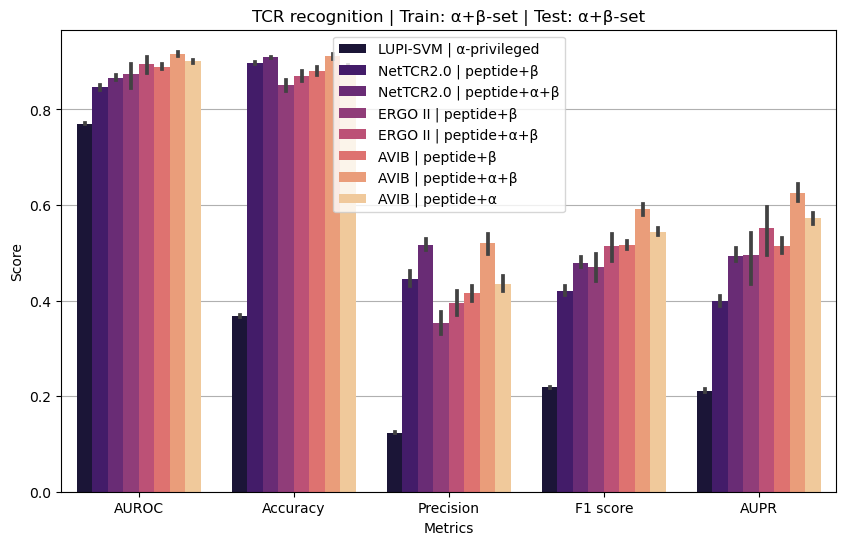

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)

results = []

for i in tqdm(range(5)):
    for predictions_file in predictions_files:
        prediction_df = predictions_file[1][i]
        if f'prediction_{i}' in prediction_df.columns:
            if "LUPI-SVM" in predictions_file[0]:
                scores_df = get_scores(
                    y_true=prediction_df['sign'].to_numpy(), 
                    y_prob=sigmoid(prediction_df[f'prediction_{i}'].to_numpy()),
                    y_pred=np.sign(prediction_df[f'prediction_{i}'].to_numpy().round()).clip(min=0),
                )
            else:
                scores_df = get_scores(
                    y_true=prediction_df['sign'].to_numpy(), 
                    y_prob=prediction_df[f'prediction_{i}'].to_numpy(),
                    y_pred=prediction_df[f'prediction_{i}'].to_numpy().round(),
                )
            scores_df['Model'] = predictions_file[0]
            results.append(scores_df)
        
results_df = pd.concat(results).rename(columns={'metrics': 'Metrics', 'score': 'Score'})

plt.rcParams['figure.figsize'] = [10, 6]
ax = sns.barplot(
    x="Metrics",
    y="Score", 
    hue="Model", 
    data=results_df,
    palette=sns.color_palette("magma", len(predictions_files))
)
ax.set_title('TCR recognition | Train: α+β-set | Test: α+β-set')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='best')
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
ax.grid(axis='y')

plt.savefig(os.path.join(FIGURES_BASE, "baseline.alpha-beta-only.svg"), format='svg', dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(FIGURES_BASE, "baseline.alpha-beta-only.png"), format='png', dpi=300, bbox_inches='tight')

In [14]:
results_df.groupby(['Metrics', 'Model']).mean()

Score
Metrics   Model                            
AUPR      AVIB | peptide+α         0.572375
          AVIB | peptide+α+β       0.625291
          AVIB | peptide+β         0.514913
          ERGO II | peptide+α+β    0.551886
          ERGO II | peptide+β      0.495088
          LUPI-SVM | α-privileged  0.211496
          NetTCR2.0 | peptide+α+β  0.494343
          NetTCR2.0 | peptide+β    0.398857
AUROC     AVIB | peptide+α         0.901097
          AVIB | peptide+α+β       0.916550
          AVIB | peptide+β         0.889271
          ERGO II | peptide+α+β    0.895463
          ERGO II | peptide+β      0.873855
          LUPI-SVM | α-privileged  0.770158
          NetTCR2.0 | peptide+α+β  0.866829
          NetTCR2.0 | peptide+β    0.846214
Accuracy  AVIB | peptide+α         0.885419
          AVIB | peptide+α+β       0.911222
          AVIB | peptide+β         0.879981
          ERGO II | peptide+α+β    0.869654
          ERGO II | peptide+β      0.850893
          LUPI-SVM | α-privileged  0.368620
          NetTCR2.0 | peptide+α+β  0.909088
          NetTCR2.0 | peptide+β    0.897017
F1 score  AVIB | peptide+α         0.544238
          AVIB | peptide+α+β       0.591812
          AVIB | peptide+β         0.516691
          ERGO II | peptide+α+β    0.513637
          ERGO II | peptide+β      0.470843
          LUPI-SVM | α-privileged  0.218223
          NetTCR2.0 | peptide+α+β  0.479377
          NetTCR2.0 | peptide+β    0.420576
Precision AVIB | peptide+α         0.434120
          AVIB | peptide+α+β       0.520418
          AVIB | peptide+β         0.415834
          ERGO II | peptide+α+β    0.395169
          ERGO II | peptide+β      0.352982
          LUPI-SVM | α-privileged  0.123383
          NetTCR2.0 | peptide+α+β  0.515378
          NetTCR2.0 | peptide+β    0.444411

In [15]:
ste = results_df.groupby(['Metrics', 'Model']).std()
ste['Score'] = ste['Score'].apply(lambda x: x / 5)
ste

Score
Metrics   Model                            
AUPR      AVIB | peptide+α         0.003009
          AVIB | peptide+α+β       0.004197
          AVIB | peptide+β         0.004202
          ERGO II | peptide+α+β    0.012438
          ERGO II | peptide+β      0.013222
          LUPI-SVM | α-privileged  0.000594
          NetTCR2.0 | peptide+α+β  0.003535
          NetTCR2.0 | peptide+β    0.002965
AUROC     AVIB | peptide+α         0.000920
          AVIB | peptide+α+β       0.001098
          AVIB | peptide+β         0.001516
          ERGO II | peptide+α+β    0.004537
          ERGO II | peptide+β      0.006537
          LUPI-SVM | α-privileged  0.000291
          NetTCR2.0 | peptide+α+β  0.001585
          NetTCR2.0 | peptide+β    0.001463
Accuracy  AVIB | peptide+α         0.001592
          AVIB | peptide+α+β       0.001364
          AVIB | peptide+β         0.001963
          ERGO II | peptide+α+β    0.002617
          ERGO II | peptide+β      0.002775
          LUPI-SVM | α-privileged  0.000654
          NetTCR2.0 | peptide+α+β  0.000392
          NetTCR2.0 | peptide+β    0.000739
F1 score  AVIB | peptide+α         0.002070
          AVIB | peptide+α+β       0.003017
          AVIB | peptide+β         0.001947
          ERGO II | peptide+α+β    0.007056
          ERGO II | peptide+β      0.007498
          LUPI-SVM | α-privileged  0.000346
          NetTCR2.0 | peptide+α+β  0.002590
          NetTCR2.0 | peptide+β    0.002331
Precision AVIB | peptide+α         0.004070
          AVIB | peptide+α+β       0.005654
          AVIB | peptide+β         0.004146
          ERGO II | peptide+α+β    0.006430
          ERGO II | peptide+β      0.005898
          LUPI-SVM | α-privileged  0.000227
          NetTCR2.0 | peptide+α+β  0.002976
          NetTCR2.0 | peptide+β    0.004045

/home/ml/kruus/anaconda3/envs/tcrmodels/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ml/kruus/anaconda3/envs/tcrmodels/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ml/kruus/anaconda3/envs/tcrmodels/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ml/kruus/anaconda3/envs/tcrmodels/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/ml/kruus/anaconda3/envs/tcrmodels/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.inter

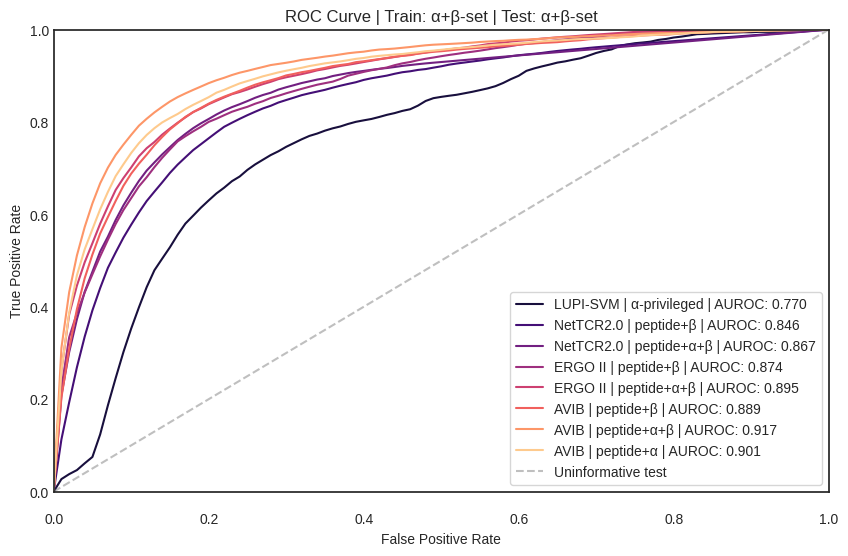

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('axes', axisbelow=True)

plt.style.use('seaborn-white')
sns.set_palette('magma', len(predictions_files))


def make_roc_curve_plot(ax, true_values_list, predicted_values_list, cutoff, model_label):
    """Calculate ROC and AUC from lists of true and predicted values and draw."""

    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    auc = []
    for true_values, predicted_values in zip(true_values_list, predicted_values_list):
        fpr, tpr, thresholds = roc_curve(true_values, predicted_values)
        auc.append(roc_auc_score(true_values, predicted_values))
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
    
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)

    ax.plot(base_fpr, mean_tprs, label=model_label+str(f" | AUROC: {statistics.mean(auc):.3f}"))
    
    ax.set_title("ROC Curve | Train: α+β-set | Test: α+β-set")
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    ax.legend()
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    
#     for fp, tp, threshold in zip(fpr, tpr, thresholds):
#         if threshold < cutoff:
#             ax.plot(fp, tp, marker='o', markersize=10, color='grey', alpha=0.75)
#             break


def make_uninformative_roc(ax):
    ax.plot([0, 1], [0, 1], c='grey', linestyle='dashed', alpha=0.5, label="Uninformative test")
    ax.legend()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(facecolor="white")


fig, ax = plt.subplots()

for predictions_file in predictions_files:
    true_values_list, predicted_values_list = [], []
    for i in range(5):
        prediction_df = predictions_file[1][i]
        true_values_list.append(prediction_df['sign'].to_numpy())
        if "LUPI-SVM" in predictions_file[0]:
            predicted_values_list.append(sigmoid(prediction_df[f'prediction_{i}'].to_numpy()))
        else:
            predicted_values_list.append(prediction_df[f'prediction_{i}'].to_numpy())

    make_roc_curve_plot(
        ax, 
        true_values_list, 
        predicted_values_list, 
        0.9,
        predictions_file[0]
    )
make_uninformative_roc(ax)
ax.tick_params(axis='x', pad=15)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='best')
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.savefig(os.path.join(FIGURES_BASE, "roc.alpha-beta-only.svg"), format='svg', dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(FIGURES_BASE, "roc.alpha-beta-only.png"), format='png', dpi=300, bbox_inches='tight')

/home/ml/kruus/anaconda3/envs/tcrmodels/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


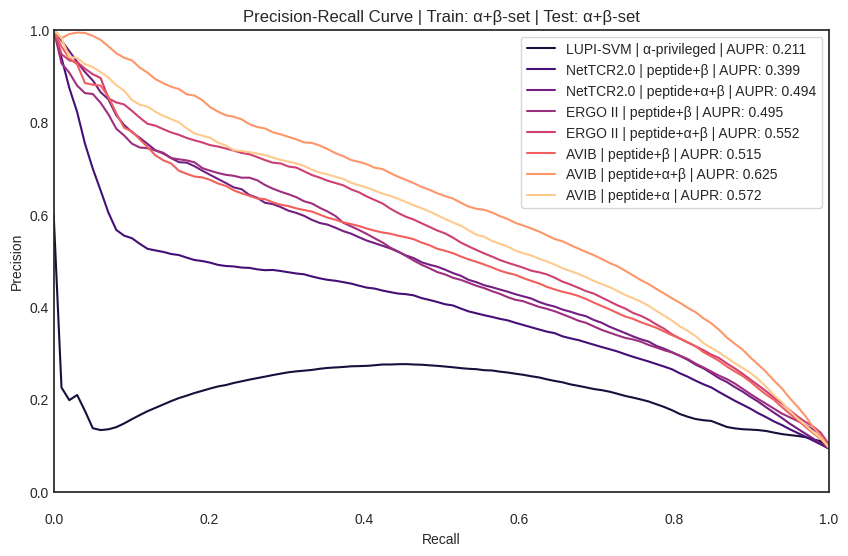

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_prc_curve_plot(ax, true_values, predicted_values, model_label):
    """Calculate PRC and AUC from lists of true and predicted values and draw."""
    
    reversed_mean_precision = 0.0
    base_recall = np.linspace(1, 0, 100)
    auc = []
    
    for true_values, predicted_values in zip(true_values_list, predicted_values_list):
        precision, recall, thresholds = precision_recall_curve(true_values, predicted_values)
        auc.append(pr_auc(true_values, predicted_values))
        reversed_recall = np.fliplr([recall])[0]
        reversed_precision = np.fliplr([precision])[0]
        reversed_mean_precision += interp(base_recall, reversed_recall, reversed_precision)
    
    reversed_mean_precision /= 5
    
    ax.plot(base_recall, reversed_mean_precision, label=model_label+str(f" | AUPR: {statistics.mean(auc):.3f}"))
    
    ax.set_title("Precision-Recall Curve | Train: α+β-set | Test: α+β-set")
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.legend()
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])


fig, ax = plt.subplots()

for predictions_file in predictions_files:
    true_values_list, predicted_values_list = [], []
    for i in range(5):
        prediction_df = predictions_file[1][i]
        true_values_list.append(prediction_df['sign'].to_numpy())
        if "LUPI-SVM" in predictions_file[0]:  # LUPI-SSVM
            predicted_values_list.append(sigmoid(prediction_df[f'prediction_{i}'].to_numpy()))
        else:
            predicted_values_list.append(prediction_df[f'prediction_{i}'].to_numpy())

    make_prc_curve_plot(
        ax, 
        true_values_list, 
        predicted_values_list, 
        predictions_file[0]
    )

ax.tick_params(axis='x', pad=15)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='best')
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.savefig(os.path.join(FIGURES_BASE, "prc.alpha-beta-only.svg"), format='svg', dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(FIGURES_BASE, "prc.alpha-beta-only.png"), format='png', dpi=300, bbox_inches='tight')

# MVIB - Experts comparison

In [18]:
import os
login = os.getlogin( )
DATA_BASE = f"/home/{login}/Git/tcr/data/"
RESULTS_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/results/"
FIGURES_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/figures/"
# To run in github checkout of vibtcr, after `unzip data.zip` ...
RESULTS_BASE = os.path.join('.', 'results')
FIGURES_BASE = os.path.join('.', 'figures')
DATA_BASE = os.path.join('..', '..', 'data')
predictions_files = [
    ('AVIB (AoE) | peptide+β', [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.bimodal.aoe.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
    ('MVIB (PoE) | peptide+β', [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.bimodal.poe.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
    ('MaxPoE | peptide+β',     [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.bimodal.max_pool.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
    ('AvgPoE | peptide+β',     [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.bimodal.avg_pool.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),

    ('AVIB (AoE) | peptide+α+β', [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.trimodal.aoe.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
    ('MVIB (PoE) | peptide+α+β', [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.trimodal.poe.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
    ('MaxPoE | peptide+α+β',     [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.trimodal.max_pool.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
    ('AvgPoE | peptide+α+β',     [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.trimodal.avg_pool.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
]

100%|██████████| 5/5 [00:00<00:00,  6.50it/s]


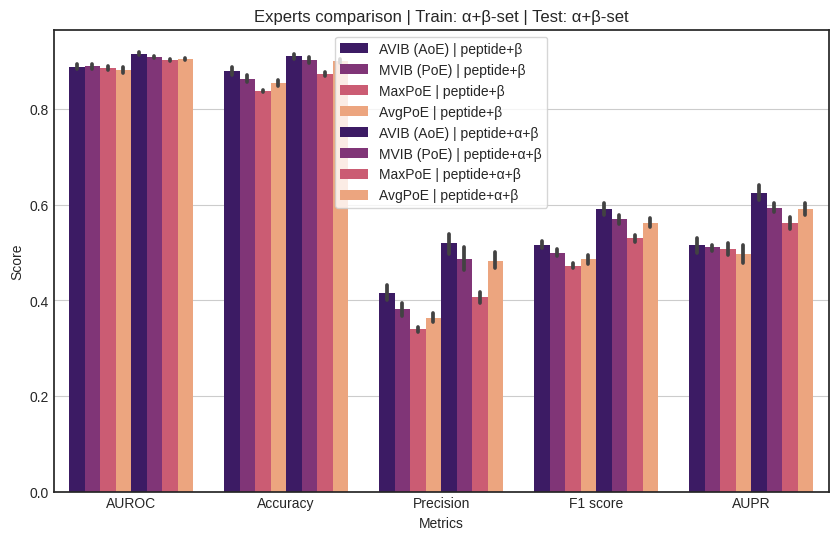

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


results = []
colors = ["#BAF1FF",  "#FDFD98", "#55DCFF", "#F5F542", ]

for i in tqdm(range(5)):
    for predictions_file in predictions_files:
        prediction_df = predictions_file[1][i]
        if f'prediction_{i}' in prediction_df.columns:
            scores_df = get_scores(
                y_true=prediction_df['sign'].to_numpy(), 
                y_prob=prediction_df[f'prediction_{i}'].to_numpy(),
                y_pred=prediction_df[f'prediction_{i}'].to_numpy().round(),
            )
            scores_df['Model'] = predictions_file[0]
            results.append(scores_df)
        
results_df = pd.concat(results).rename(columns={'metrics': 'Metrics', 'score': 'Score'})

plt.rcParams['figure.figsize'] = [10, 6]
ax = sns.barplot(
    x="Metrics",
    y="Score", 
    hue="Model", 
    data=results_df,
    palette=sns.color_palette('magma', 4)
)
ax.set_title('Experts comparison | Train: α+β-set | Test: α+β-set')
ax.legend(loc='best')
ax.grid(axis='y')
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.savefig(os.path.join(FIGURES_BASE, "experts-comparison.svg"), format='svg', dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(FIGURES_BASE, "experts-comparison.png"), format='png', dpi=300, bbox_inches='tight')

In [20]:
results_df.groupby(['Metrics', 'Model']).mean()

Score
Metrics   Model                             
AUPR      AVIB (AoE) | peptide+α+β  0.625291
          AVIB (AoE) | peptide+β    0.514913
          AvgPoE | peptide+α+β      0.591147
          AvgPoE | peptide+β        0.497207
          MVIB (PoE) | peptide+α+β  0.593917
          MVIB (PoE) | peptide+β    0.510777
          MaxPoE | peptide+α+β      0.562071
          MaxPoE | peptide+β        0.507381
AUROC     AVIB (AoE) | peptide+α+β  0.916550
          AVIB (AoE) | peptide+β    0.889271
          AvgPoE | peptide+α+β      0.905229
          AvgPoE | peptide+β        0.881346
          MVIB (PoE) | peptide+α+β  0.909873
          MVIB (PoE) | peptide+β    0.889540
          MaxPoE | peptide+α+β      0.903327
          MaxPoE | peptide+β        0.886099
Accuracy  AVIB (AoE) | peptide+α+β  0.911222
          AVIB (AoE) | peptide+β    0.879981
          AvgPoE | peptide+α+β      0.901730
          AvgPoE | peptide+β        0.854939
          MVIB (PoE) | peptide+α+β  0.902630
          MVIB (PoE) | peptide+β    0.864254
          MaxPoE | peptide+α+β      0.873347
          MaxPoE | peptide+β        0.837810
F1 score  AVIB (AoE) | peptide+α+β  0.591812
          AVIB (AoE) | peptide+β    0.516691
          AvgPoE | peptide+α+β      0.562403
          AvgPoE | peptide+β        0.485843
          MVIB (PoE) | peptide+α+β  0.569868
          MVIB (PoE) | peptide+β    0.499921
          MaxPoE | peptide+α+β      0.530127
          MaxPoE | peptide+β        0.472794
Precision AVIB (AoE) | peptide+α+β  0.520418
          AVIB (AoE) | peptide+β    0.415834
          AvgPoE | peptide+α+β      0.482426
          AvgPoE | peptide+β        0.363483
          MVIB (PoE) | peptide+α+β  0.487596
          MVIB (PoE) | peptide+β    0.382042
          MaxPoE | peptide+α+β      0.406147
          MaxPoE | peptide+β        0.339482

In [21]:
std_df = results_df.groupby(['Metrics', 'Model']).std()
std_df['Score'] = std_df['Score'].apply(lambda x: x / 5)
std_df

Score
Metrics   Model                             
AUPR      AVIB (AoE) | peptide+α+β  0.004197
          AVIB (AoE) | peptide+β    0.004202
          AvgPoE | peptide+α+β      0.003172
          AvgPoE | peptide+β        0.005157
          MVIB (PoE) | peptide+α+β  0.002372
          MVIB (PoE) | peptide+β    0.001677
          MaxPoE | peptide+α+β      0.002983
          MaxPoE | peptide+β        0.003282
AUROC     AVIB (AoE) | peptide+α+β  0.001098
          AVIB (AoE) | peptide+β    0.001516
          AvgPoE | peptide+α+β      0.000719
          AvgPoE | peptide+β        0.001591
          MVIB (PoE) | peptide+α+β  0.000673
          MVIB (PoE) | peptide+β    0.001211
          MaxPoE | peptide+α+β      0.000583
          MaxPoE | peptide+β        0.001193
Accuracy  AVIB (AoE) | peptide+α+β  0.001364
          AVIB (AoE) | peptide+β    0.001963
          AvgPoE | peptide+α+β      0.001057
          AvgPoE | peptide+β        0.001486
          MVIB (PoE) | peptide+α+β  0.001705
          MVIB (PoE) | peptide+β    0.001814
          MaxPoE | peptide+α+β      0.001240
          MaxPoE | peptide+β        0.000558
F1 score  AVIB (AoE) | peptide+α+β  0.003017
          AVIB (AoE) | peptide+β    0.001947
          AvgPoE | peptide+α+β      0.002180
          AvgPoE | peptide+β        0.002385
          MVIB (PoE) | peptide+α+β  0.002384
          MVIB (PoE) | peptide+β    0.001889
          MaxPoE | peptide+α+β      0.001905
          MaxPoE | peptide+β        0.001565
Precision AVIB (AoE) | peptide+α+β  0.005654
          AVIB (AoE) | peptide+β    0.004146
          AvgPoE | peptide+α+β      0.004160
          AvgPoE | peptide+β        0.002367
          MVIB (PoE) | peptide+α+β  0.006133
          MVIB (PoE) | peptide+β    0.003284
          MaxPoE | peptide+α+β      0.002975
          MaxPoE | peptide+β        0.001231